# <center> <b>Age Prediction

## <b>Introduction

Age prediction is a popular problem in computer vision under the umbrella of pattern recognition. As a technical perspective, this problem is widely used to test new computer vision algorithms. There are plenty of new models developed in this recent years according to the increase in high computation power, and two main benchmarks used to evaluate how much they can defeat the previous models are accuracy and time consumption.<br>

For application, age prediction is also beneficial to many areas when forgetting about privacy. An example is a business such as a supermarket. The manager will be able to know how customers in each age group walk through a shelf-stacker differently. The information can be used to rearrange goods for more appropriate with the target group and better income.<br>

Two deep learning models, ResNet (Residual Networks) and VGG (Visual Geometry Group), will be used in this study for age prediction. ImageNet and VGGface are used as the model weight, respectively. These model performances will be compared together in the condition that all layers are frozen. The model which provides the best result will be tested further by releasing weight for more layers. Finally, this process will end when the model performance drops along with adding more trainable layers.<br>

The datasorce used in this study is from https://talhassner.github.io/home/projects/Adience/Adience-data.html.

## <b> Methodology

To do an age prediction, there are 6 main processes as below; <br>
1. Prepare working environment
2. Load data (in this case, the data is images)
3. Preprocess data
4. Construct and test prediction models
5. Evaluate the model performance
6. Conclude and discuss the result

## <b>Get Start!

### <B> 1. Prepare working environment

Install new libraries

In [ ]:
!pip install -q keras_tqdm

# clone library from github and check if it is dowloaded successfully
!sudo pip install git+https://github.com/rcmalli/keras-vggface.git
!pip show keras-vggface

Load data through console

In [ ]:
# download and extract aligned.tar using console
wget --user adiencedb --password adience http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/aligned.tar.gz

# extract field
tar xvzf aligned.tar.gz

Import all used libraries

In [226]:
# for loading image
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import pandas as pd
import os
from collections import OrderedDict

# for constructinf and testing deeplearning model
import tensorflow as tf
import keras
from keras import backend as K
from keras import initializers
from keras_tqdm import TQDMNotebookCallback
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.applications.resnet50 import ResNet50
from keras_vggface.vggface import VGGFace
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
import random as rn

# model evaluation and visualization
import model_evaluation as model_eval # udf
from sklearn.metrics import f1_score, balanced_accuracy_score
from matplotlib import pyplot as plt
import seaborn as sns
import cv2

In [199]:
# check if tensorflow runs on GPU
tf.test.gpu_device_name() #0 means use 1 unit of GPU

'/device:GPU:0'

In [200]:
# Fix random seed for reproducibility
seed = 27

# Setting the seed for numpy-generated random numbers
np.random.seed(seed)

# Setting the seed for python random numbers
rn.seed(seed)

# Setting the graph-level random seed
tf.set_random_seed(seed)

#Force Tensorflow to use a single thread
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

#Force Tensorflow to use a single thread
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

### <B>2. Load data

This study loads images using batch approach. Besides, file paths are separated into train/ test/ validation set instead of raw images with the objective to reduce memory consumption.

In [201]:
# udf to load image index
data_path = 'data_source/'

def importdata(filename):
    fold = pd.read_csv(data_path + filename + '.txt', sep = '\t') #seperator as tab
    fold['path'] = fold.apply(lambda x: data_path + 'aligned/' + x['user_id'] + '/landmark_aligned_face.{}.{}'.format(x['face_id'], x['original_image']), axis=1)
        # The structure of a file name in aligned is as below;
            # user_id -- the no to identify face group (similar faces are groedas 1 user id although they are from different people) and it is used as the subfolder name
            # landmark_aligned_face. -- the prefix of each file in the subfolder
            # face_id. -- the no to identify a particular user (a person has 1 face id)
            # original_image -- the id of each image
    return fold

In [202]:
# load image index
fold_list = []

for i in np.arange(0,5):
    fold_list.append('fold_'+str(i)+'_data')
    if i == 0:
        fold = importdata('fold_'+str(i)+'_data')
    else:
        _ = importdata('fold_'+str(i)+'_data')
        fold = fold.append(_, ignore_index=True).reset_index(drop=True)

In [203]:
# explore the loaded image index
fold.head(2)

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score,path
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17,data_source/aligned/30601258@N03/landmark_alig...
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94,data_source/aligned/30601258@N03/landmark_alig...


> The image index from fold0 (first fold) is loaded successfully.

In [204]:
# explore the loaded image index
fold.tail(2)

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score,path
19368,7153718@N04,11598145163_733cb99713_o.jpg,2282,None,NaN,1027,946,408,408,-85,0,49,data_source/aligned/7153718@N04/landmark_align...
19369,7153718@N04,11598013005_240c2bc9c7_o.jpg,2282,None,NaN,498,643,772,772,-80,0,111,data_source/aligned/7153718@N04/landmark_align...


> The image index from fold4 (last fold) is loaded successfully.

### <B>3. Preprocess data

This step includes 2 main topics. They are data cleansing and train-test-validation splitting.<br>

The phrase "garbage in, garbage out" is a classic phrase in the field of data analytics. Poor data quality will confuse the model, and the result of such information cannot solve the problem in the real setting. Therefore, data cleansing is a vital task before doing further steps, and model performance usually depends on how well the data quality is.

Train-set-validation splitting is to separate data into 3 groups for particular objectives. They are to construct a model, tune the model hyperparameters, and evaluate the model performance.

- <B>Clean data

First and foremost, data profiling are explored

In [205]:
# explore data
print('total images: {}'.format(len(fold)))
print('total images which do not contain "age": {}'.format(len(fold.loc[fold.age=='None',:])))
print('total images with complete data: {}'.format(len(fold.loc[fold.age!='None',:])))
fold_list

total images: 19370
total images which do not contain "age": 748
total images with complete data: 18622


['fold_0_data', 'fold_1_data', 'fold_2_data', 'fold_3_data', 'fold_4_data']

> The data are inlcuded from 5 folds (0 to 4) consisting of 19,370 cases. Unfortunately, a total of 748 images does not contain target class and they are excluded during model development phrase.

The data without labels is useless during model development, so they are removed.

In [206]:
# remove index which the images are not labeled age
fold_complete = fold.loc[fold.age!='None',:].copy()
print('total images left: {}'. format(len(fold_complete)))

total images left: 18622


Then the labels are explored to see their possible values.

In [207]:
# find the possible labels
set(fold_complete['age'])

{'(0, 2)',
 '(15, 20)',
 '(25, 32)',
 '(27, 32)',
 '(38, 42)',
 '(38, 43)',
 '(38, 48)',
 '(4, 6)',
 '(48, 53)',
 '(60, 100)',
 '(8, 12)',
 '(8, 23)',
 '13',
 '2',
 '22',
 '23',
 '29',
 '3',
 '32',
 '34',
 '35',
 '36',
 '42',
 '45',
 '46',
 '55',
 '56',
 '57',
 '58'}

> The result of this step presents that the target class is inconsistency. This study designs to solve this issue by regrouping the label. However, another solution is to remove them if the inconsistency classes have a small number.

<i>Regroup target classes

In [208]:
# relabel age group
dict_agegr = {'(0, 2)': '(00-06)',
              '2': '(00-06)',
              '3': '(00-06)',
              '(4, 6)': '(00-06)',
              '(8, 12)': '(07-23)',
              '13': '(07-23)',
              '(15, 20)': '(07-23)',
              '22': '(07-23)',
              '23': '(07-23)',
              '(8, 23)': '(07-23)',
              '(25, 32)': '(24-32)',
              '29': '(24-32)',
              '(27, 32)': '(24-32)',
              '32': '(24-32)',
              '34': '(33-54)',
              '35': '(33-54)',
              '36': '(33-54)',
              '(38, 42)': '(33-54)',
              '(38, 43)': '(33-54)',
              '(38, 48)': '(33-54)',
              '42': '(33-54)',
              '(48, 53)': '(33-54)',
              '45': '(33-54)',
              '46': '(33-54)',
              '55': '(55-100)',
              '56': '(55-100)',
              '57': '(55-100)',
              '58': '(55-100)',
              '(60, 100)': '(55-100)'}

fold_complete['age_gr'] = fold_complete['age'].copy()
fold_complete = fold_complete.replace({'age_gr': dict_agegr})

# explore the possible labels
set(fold_complete['age_gr'])

{'(00-06)', '(07-23)', '(24-32)', '(33-54)', '(55-100)'}

> Finally, there are 5 target classes included in this study.

In [209]:
# check if there is any 'None' age
fold_complete.loc[fold_complete.age_gr=='None', ['age', 'age_gr']]

,age,age_gr


> There is not any unlabel case left.

In [210]:
print('00-06: {}'.format(len(fold_complete.loc[fold_complete.age_gr=='(00-06)',])))
print('07-23: {}'.format(len(fold_complete.loc[fold_complete.age_gr=='(07-23)',])))
print('24-32: {}'.format(len(fold_complete.loc[fold_complete.age_gr=='(24-32)',])))
print('33-54: {}'.format(len(fold_complete.loc[fold_complete.age_gr=='(33-54)',])))
print('56-100: {}'.format(len(fold_complete.loc[fold_complete.age_gr=='(55-100)',])))

00-06: 4649
07-23: 4180
24-32: 5095
33-54: 3719
56-100: 979


> The result from regrouping shows that the number member in each group is different, especially for the group of 56 to 100 years old. This characteristic might affect the model performance in this age group prediction.

<i>Encode new target class

This step is done according to the model requirement. Both models, ResNet50 and VGG16, need input to be in numerical form (string is unacceptable).

In [211]:
dict_agegr2 = {'(00-06)': 0,
               '(07-23)': 1,
               '(24-32)': 2,
               '(33-54)': 3,
               '(55-100)': 4}
dict_agegr2

{'(00-06)': 0, '(07-23)': 1, '(24-32)': 2, '(33-54)': 3, '(55-100)': 4}

In [212]:
# explore encoding result
fold_complete = fold_complete.replace({'age_gr': dict_agegr2})
fold_complete.loc[:, ['age', 'age_gr']].head(5)

,age,age_gr
0,"(25, 32)",2
1,"(25, 32)",2
2,"(25, 32)",2
3,"(25, 32)",2
4,"(25, 32)",2


In [213]:
# check the final result
set(fold_complete['age_gr'])

{0, 1, 2, 3, 4}

- <b> Split data into train/ test/ and validation set

Firstly, file path and label class are extracted from the image index.

In [214]:
# keep only filename and y as list
filenames = list(fold_complete['path'])
labels = list(fold_complete['age_gr'])

Typically this step will split the data directly; however, the study uses data path instead. The data will be loaded automatically to the model during model development.

In [215]:
# udf for spliting data
def split(X, y, test_size):
    Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size = test_size, random_state = seed, stratify = y)
    return Xtrn, Xtst, ytrn, ytst

# split data
Xtrn, Xtstval, ytrn, ytstval = split(filenames.copy(), labels.copy(), test_size = 0.3) # file path and label for training set
Xtst, Xval, ytst, yval = split(Xtstval, ytstval, test_size = 0.5) # file path and label for test and validation set

Batch loading is the method used to feed data to the model in this study according to memory constraint.

In [216]:
# create new class to import data as batch
# inherit from the Sequence class
class Custom_Generator(keras.utils.Sequence):   
    
    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        
    # find total number of batches -- dunder methods
    def __len__(self):
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)   
    
    # gather images for each batch -- dunder methods
    def __getitem__(self, idx):        
        batch_x = self.image_filenames[idx*self.batch_size:(idx+1)*self.batch_size] # load x by batch number
        batch_y = self.labels[idx*self.batch_size:(idx+1)*self.batch_size] # load y by batch number  
        
        # augment images
        im_aug = ImageDataGenerator(rotation_range=6, width_shift_range=0.1, height_shift_range=0.1,
                                    horizontal_flip=True, zoom_range=0.1)
        
        # load images
        # resize images - 1=color/ 0=grayscale/ -1=unchanged
        # augment images
        datagen = np.array([im_aug.random_transform(cv2.resize(cv2.imread(file_name, 1), (224, 224),
                                        interpolation = cv2.INTER_AREA)) for file_name in batch_x], dtype='float32')
        
        # scale images 0-1 - divided by 255
        return datagen/255.0, np.array(batch_y)

Finally, the number of batch size is set and 3 data sets which inlcude batch loading pipline are prepared.

In [217]:
# load each data set as batch
batch_size = 64

training_batch_generator = Custom_Generator(Xtrn, ytrn, batch_size)
testing_batch_generator = Custom_Generator(Xtst, ytst, batch_size)
validation_batch_generator = Custom_Generator(Xval, yval, batch_size)

# check model input type
testing_batch_generator.__getitem__(1)[0][0][0][0].dtype

dtype('float32')

#### <B> 4. Contruct and test prediction models

This study objective is to predict age from images. There are 2 deep learning models used together with 3 pre-trained-weight, ResNet50 and VGG16.

#### <b> 4.1) Experiment model with original weight

#### <b>I) ResNet50

ResNet is developed with the idea to reduce vanising gradient by shortcut connection. This techique is called 'residual block' and the model is claimed to not decline performace over the layer depth.<br>

<i>ResNet50 Structure:<br>
 ![](./fig/0_ResNet50.PNG)<br>
Source: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33</i>

<i>Residual Block:<br>
![](./fig/1_Residual_block.PNG)<br>
Source: https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035</i>

In the case of imagenet, it is a large image database which its objective is to use in object recognition research. There are more than 14 million images included with a total of 20,000 categories.

<i>Examples from ImageNet:<br>
![](./fig/2_Examples_ImageNet.PNG)<br>
Source: Chen, Chen & Ren, Yuzhuo & Jay Kuo, C.-C. (2016). Global-Attributes Assisted Outdoor Scene Geometric Labeling. 10.1007/978-981-10-0631-9_5. </i>

ResNet50 structure is loaded together with pre-train-weight from "imagenet", then it is used as a basemodel.

In [ ]:
# load model struture with pre-train-weight
    # include_top = Fasle --> not include final pooling and dense
resnet_model = ResNet50(weights='imagenet', include_top=False)

# check based model structure
resnet_model.summary()

Try freezing weight at each layer at the first place.

In [23]:
# freeze all layers in basemodel
for layer in resnet_model.layers:
    layer.trainable = False

Config top layers to fit with this study problem

In [24]:
# add more layers in basemodel
finlayer = resnet_model.output # extract the list of output tensor
finlayer = GlobalMaxPooling2D()(finlayer)
finlayer = Dense(100, activation='relu')(finlayer)
finlayer = Dense(50, activation='relu')(finlayer)
finlayer = Dense(len(set(ytrn)), activation='softmax')(finlayer)

Construct the final model

In [ ]:
# combine layer from ResNet model and final added layers
resnet_ori_model = Model(resnet_model.input, finlayer, name='resnet_ori_model')

resnet_ori_model.compile(loss='sparse_categorical_crossentropy',
                         optimizer=keras.optimizers.Adadelta(),
                         metrics=['acc'])

# # check model structure
# resnet_ori_model.summary()

> There are 23,587,712 parameters to be frozen. The others will be trained using images from training set.

Set early stopping and model checkpoint criteria

In [29]:
# set early stop
early_stopping = keras.callbacks.EarlyStopping(patience=10, min_delta = 0.0001,
                                               restore_best_weights=True, monitor='val_loss')

# set model checkpoint at the best performance
checkpoint = keras.callbacks.ModelCheckpoint('./model_log/resnet_ori_log.h5', monitor='val_acc', save_best_only=True)

Since this study has imbalanced data set, classe weight is set. Then accuracy can be used as model evaluation.

In [ ]:
# make each class equal improtance
class_weights=compute_class_weight('balanced', np.unique(ytrn), ytrn)

Fit model with images frome training set and test it with test set. During this step, the images will be retrived from the the paths batch-to-batch.

In [ ]:
# tes model
history = resnet_ori_model.fit_generator(generator=training_batch_generator,
                                         steps_per_epoch = int(training_batch_generator.__len__()),
                                         epochs = 300, verbose = 1,
                                         validation_data = validation_batch_generator, 
                                         validation_steps = int(validation_batch_generator.__len__()),
                                         callbacks=[checkpoint, early_stopping],
                                         workers=10, 
                                         class_weight=class_weights)

# save weight from the trained model
joblib.dump(history, './model_log/bestmodel/resnet_ori_model.pkl')

In [ ]:
# restore the model
resnet_ori_best = joblib.load('./model_log/bestmodel/resnet_ori_model.pkl')

Explore the original model performance

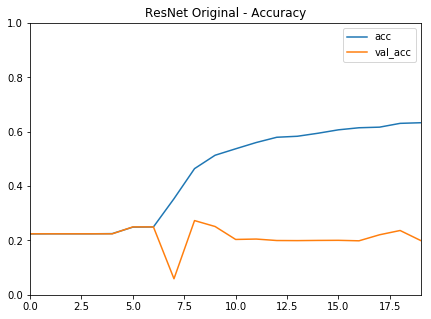

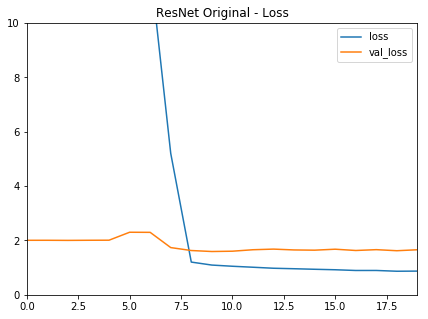

In [23]:
pd.DataFrame(resnet_ori_best.history).loc[:,['acc','val_acc']].plot(figsize=(7, 5))
plt.title('ResNet Original - Accuracy')
plt.ylim(0,1)
plt.grid(False)
plt.show()

pd.DataFrame(resnet_ori_best.history).loc[:,['loss','val_loss']].plot(figsize=(7, 5))
plt.title('ResNet Original - Loss')
plt.ylim(0,10)
plt.grid(False)
plt.show()

In [24]:
print('best train accuracy: {:.4f}'.format(resnet_ori_best.history['acc'][np.argmax(resnet_ori_best.history['val_acc'])]))
print('best test accuracy: {:.4f}'.format(max(resnet_ori_best.history['val_acc'])))

best train accuracy: 0.4642
best test accuracy: 0.2731


> The result from ResNet50 presents that both train and test performance are less than 50%. In other word, random guess is more likely to correct than this model prediction.

#### <b>2. VGG16

VGG16 is a convolutional neural network model. There are 16 layers included which are 13 convoluation and 3 dense layers.

<i>VGG16 Structure:<br>
 ![](./fig/3_VGG16.PNG)<br>
Source: https://neurohive.io/en/popular-networks/vgg16/</i>

VGGFace is a dataset contains about 2,000 unique identities. There are  more than two million faces included in the dataset.

<i>Examples from VGGFace:<br>
 ![](./fig/4_VGGface.PNG)<br>
Source: https://www.analyticsvidhya.com/blog/2018/07/top-10-pretrained-models-get-started-deep-learning-part-1-computer-vision/</i>

VGG16 structure is loaded together with pre-train-weight from "VGGFace", then it is used as a basemodel.

In [ ]:
# load model struture with pre-train-weight
    # include_top = Fasle --> not include final pooling and dense
vgg_model = VGGFace(model='vgg16', include_top=False, weights='vggface', pooling='max')

# check based model structure
#vgg_model.summary()

Try freezing weight at each layer at the first place.

In [36]:
# freeze all layers in basemodel
for layer in vgg_model.layers:
    layer.trainable = False

Config top layers to fit with this study problem

In [37]:
# add more layers in basemodel
finlayer2 = vgg_model.output # extract the list of output tensor
finlayer2 = Dense(100, activation='relu')(finlayer2)
finlayer2 = Dense(50, activation='relu')(finlayer2)
finlayer2 = Dense(len(set(ytrn)), activation='softmax')(finlayer2)

Construct the final model

In [ ]:
# combine layer from VGG model and final added layers
vgg_ori_model = Model(vgg_model.input, finlayer2, name='vgg_ori_model')

vgg_ori_model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['acc'])

# check model structure
vgg_ori_model.summary()

> There are 26,092,144 parameters to be freezed. Comparing to ResNet (n param = 23,587,712), VGG16 has more parameters included.

Early stopping used in this model is the same as ResNet50 experoment. Hence, only model checkpoint criteria is set.

In [39]:
# save only best model
checkpoint = keras.callbacks.ModelCheckpoint('./model_log/vgg_ori_log.h5', monitor='val_acc', save_best_only=True)

Fit model with images frome training set and test it with test set. During this step, the images will be retrived from the the paths batch-to-batch.

In [ ]:
# test the model
history = vgg_ori_model.fit_generator(generator=training_batch_generator,
                                      steps_per_epoch = int(training_batch_generator.__len__()),
                                      epochs = 300, verbose = 1,
                                      validation_data = validation_batch_generator, 
                                      validation_steps = int(validation_batch_generator.__len__()),
                                      callbacks=[checkpoint, early_stopping],
                                      workers=10, 
                                      class_weight=class_weights)

# save weight from the trained model
joblib.dump(history, './model_log/bestmodel/vgg_ori_model.pkl')

In the case that kernel is die during model experiment, the model at the last checkpoing can be used to continue the experiment for saving time.

In [ ]:
# continue training model in case that the kernel is interrupted
vgg_ori_model.load_weights('./model_log/vgg_ori_log.h5')

# test the model
history = vgg_ori_model.fit_generator(generator=training_batch_generator,
                                      steps_per_epoch = int(training_batch_generator.__len__()),
                                      epochs = 300, verbose = 1,
                                      validation_data = validation_batch_generator, 
                                      validation_steps = int(validation_batch_generator.__len__()),
                                      callbacks=[checkpoint, early_stopping],
                                      workers=10, 
                                      class_weight=class_weights)

# save weight from the trained model
joblib.dump(history, './model_log/bestmodel/vgg_ori_model.pkl')

In [187]:
# restore the best model
vgg_ori_best = joblib.load('./model_log/bestmodel/vgg_ori_model.pkl')

Explore the original model performance

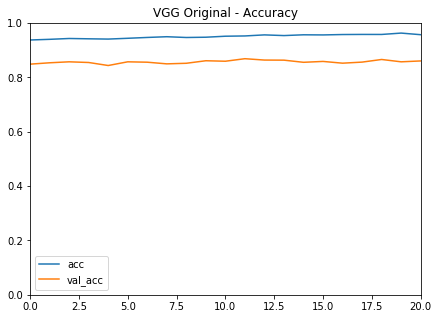

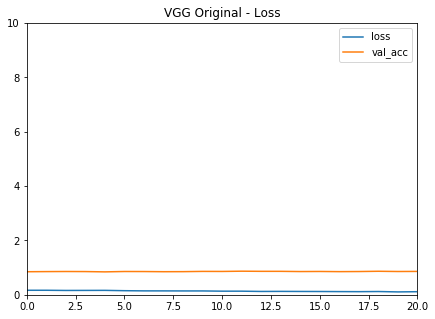

In [188]:
pd.DataFrame(vgg_ori_best.history).loc[:,['acc','val_acc']].plot(figsize=(7, 5))
plt.ylim(0,1)
plt.title('VGG Original - Accuracy')
plt.grid(False)
plt.show()

pd.DataFrame(vgg_ori_best.history).loc[:,['loss','val_acc']].plot(figsize=(7, 5))
plt.ylim(0,10)
plt.title('VGG Original - Loss')
plt.grid(False)
plt.show()

In [190]:
print('best train accuracy: {:.4f}'.format(vgg_ori_best.history['acc'][np.argmax(vgg_ori_best.history['val_acc'])]))
print('best test accuracy: {:.4f}'.format(max(vgg_ori_best.history['val_acc'])))

best train accuracy: 0.9524
best test accuracy: 0.8686


> The result from VGG16 presents that both train and test performance is a lot better than ResNet50 (train accuracy: 0.4642, test accuracy: 0.2731). Hence, VGG16 will be tested in further step.

#### <b> 4.2) Config model - release weight in some layers

This step will try releasing some weights and train the model to see how the performance will change. Only VGG16 will adopt as the model structure since it is the best model from previous step.

- <b> 1st Round

Firstly, the model index are explored.

In [40]:
# find each layer index
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name)

0 input_2
1 conv1_1
2 conv1_2
3 pool1
4 conv2_1
5 conv2_2
6 pool2
7 conv3_1
8 conv3_2
9 conv3_3
10 pool3
11 conv4_1
12 conv4_2
13 conv4_3
14 pool4
15 conv5_1
16 conv5_2
17 conv5_3
18 pool5
19 global_max_pooling2d_2


Only the weights from top 2 layers are trained.

In [45]:
release_index = 18

# release trainable weight from some layers
    # fix weight
for layer in vgg_model.layers[:release_index]:
    layer.trainable = False
    # trian weight
for layer in vgg_model.layers[release_index:]:
    layer.trainable = True

In [ ]:
# combine the model
vgg_config_model = Model(vgg_model.input, finlayer2, name='vgg_config_model')

# save only best model
checkpoint = keras.callbacks.ModelCheckpoint('./model_log/vgg_config_log.h5', monitor='val_acc', save_best_only=True)

vgg_config_model.compile(loss='sparse_categorical_crossentropy',
                         optimizer=keras.optimizers.Adadelta(),
                         metrics=['acc'])

# check model structure
vgg_config_model.summary()

In [ ]:
# test the model
history = vgg_config_model.fit_generator(generator=training_batch_generator,
                                         steps_per_epoch = int(training_batch_generator.__len__()),
                                         epochs = 300, verbose = 1,
                                         validation_data = validation_batch_generator, 
                                         validation_steps = int(validation_batch_generator.__len__()),
                                         callbacks=[checkpoint, early_stopping],
                                         workers=10, 
                                         class_weight=class_weights)

# save weight from the trained model
joblib.dump(history, './model_log/bestmodel/vgg_config_model.pkl')

In [191]:
# restore the best model
vgg_config_best = joblib.load('./model_log/bestmodel/vgg_config_model.pkl')

best train accuracy: 0.9692
best test accuracy: 0.8701


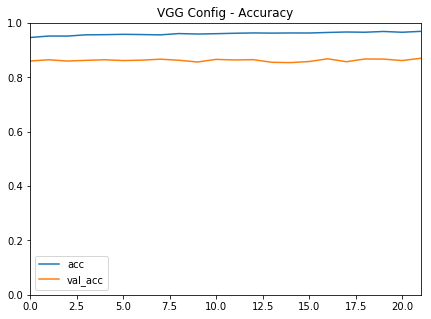

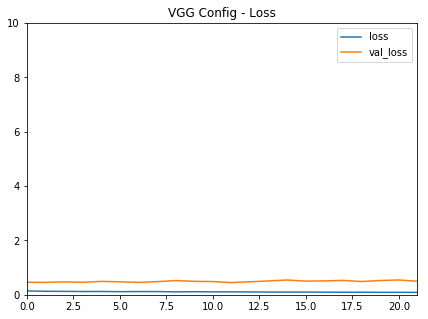

In [58]:
# explore the result
pd.DataFrame(vgg_config_best.history).loc[:,['acc','val_acc']].plot(figsize=(7, 5))
plt.title('VGG Config - Accuracy')
plt.ylim(0,1)
plt.grid(False)
plt.show()

pd.DataFrame(vgg_config_best.history).loc[:,['loss','val_loss']].plot(figsize=(7, 5))
plt.title('VGG Config - Loss')
plt.ylim(0,10)
plt.grid(False)
plt.show()

In [192]:
print('best train accuracy: {:.4f}'.format(vgg_config_best.history['acc'][np.argmax(vgg_config_best.history['val_acc'])]))
print('best test accuracy: {:.4f}'.format(max(vgg_config_best.history['val_acc'])))

best train accuracy: 0.9692
best test accuracy: 0.8701


> After set weights at the top 2 layers of VGG16, the model accuracy slightly increases both in train and test set (original VGG - train accuracy: 0.9524, test accuracy: 0.8686).

- <b> 2nd Round

At this time, more weights will be released.

In [59]:
release_index = 15

# release trainable weight from some layers
    # fix weight
for layer in vgg_model.layers[:release_index]:
    layer.trainable = False
    # trian weight
for layer in vgg_model.layers[release_index:]:
    layer.trainable = True

In [ ]:
# combine the model
vgg_config2_model = Model(vgg_model.input, finlayer2, name='vgg_config2_model')

# save only best model
checkpoint = keras.callbacks.ModelCheckpoint('./model_log/vgg_config2_log.h5', monitor='val_acc', save_best_only=True)

vgg_config2_model.compile(loss='sparse_categorical_crossentropy',
                         optimizer=keras.optimizers.Adadelta(),
                         metrics=['acc'])

# check model structure
vgg_config2_model.summary()

In [ ]:
# test the model
history = vgg_config2_model.fit_generator(generator=training_batch_generator,
                                          steps_per_epoch = int(training_batch_generator.__len__()),
                                          epochs = 300, verbose = 1,
                                          validation_data = validation_batch_generator, 
                                          validation_steps = int(validation_batch_generator.__len__()),
                                          callbacks=[checkpoint, early_stopping],
                                          workers=10, 
                                          class_weight=class_weights)

# save weight from the trained model
joblib.dump(history, './model_log/bestmodel/vgg_config2_model.pkl')

In [193]:
# restore the best model
vgg_config2_best = joblib.load('./model_log/bestmodel/vgg_config2_model.pkl')

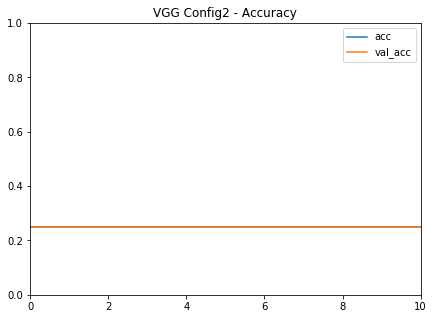

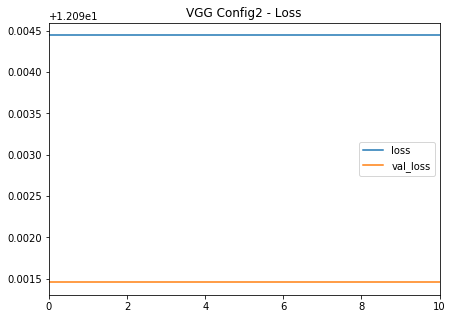

In [194]:
# explore the result
pd.DataFrame(vgg_config2_best.history).loc[:,['acc','val_acc']].plot(figsize=(7, 5))
plt.title('VGG Config2 - Accuracy')
plt.ylim(0,1)
plt.grid(False)
plt.show()

pd.DataFrame(vgg_config2_best.history).loc[:,['loss','val_loss']].plot(figsize=(7, 5))
plt.title('VGG Config2 - Loss')
plt.grid(False)
plt.show()

In [195]:
print('best train accuracy: {:.4f}'.format(vgg_config2_best.history['acc'][np.argmax(vgg_config2_best.history['val_acc'])]))
print('best test accuracy: {:.4f}'.format(max(vgg_config2_best.history['val_acc'])))

best train accuracy: 0.2496
best test accuracy: 0.2498


The model after releasing more weights drops performance more than 50%. Accordingly, the model configuration stops at this step because performance does not increase by the trainable weight.

### <B> 5. Evaluate the model performance

The best model according above experiment is VGG16 with trainable weight at top2 layers. This step will evaluate the model performance tincluding;
- Accuracy
- Confusion matrix
- ROC
- PR cruve
- Weighted accuracy and F1

In [53]:
# restore best of the best model
best_model = joblib.load('./model_log/bestmodel/vgg_config_model.pkl')

- <b> Accuracy

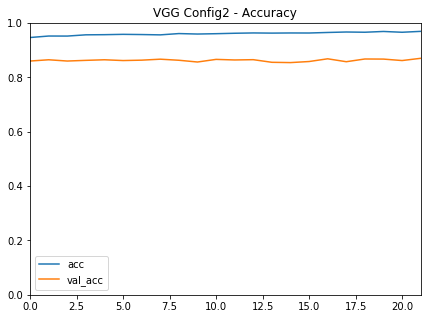

In [54]:
# explore the result
pd.DataFrame(best_model.history).loc[:,['acc','val_acc']].plot(figsize=(7, 5))
plt.title('VGG Config2 - Accuracy')
plt.ylim(0,1)
plt.grid(False)
plt.show()

Find accuracy and loss of validation set

In [55]:
print(best_model.model.metrics_names)
loss, acc = best_model.model.evaluate_generator(generator=validation_batch_generator, steps=int(validation_batch_generator.__len__()), workers=10, verbose=1)

['loss', 'acc']
44/44 [==============================] - 15s 339ms/step


In [56]:
i = np.argmax(best_model.history['val_acc'])
print('train accuracy: {:.4f}'.format(best_model.history['acc'][i]))
print('test accuracy: {:.4f}'.format(max(best_model.history['val_acc'])))
print('validation accuracy: {:.4f}\n'.format(acc))

train accuracy: 0.9692
test accuracy: 0.8701
validation accuracy: 0.8615



> This result shows that the model performance just slightly drops from the test set.

Predict target class and each class probability of validation set

In [57]:
yprob = best_model.model.predict_generator(generator=validation_batch_generator, steps=int(validation_batch_generator.__len__()), workers=10, verbose=1)
ypred = np.argmax(yprob,axis=1)

44/44 [==============================] - 18s 403ms/step


- <b> Confusion Matrix

This study has imbalanced class data. Therefore, confusion matrix with normalization is used.

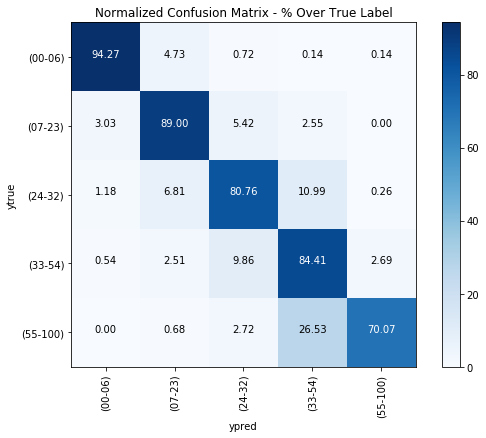

In [96]:
model_eval.cm_plot(yval, yprob, normalize=True, label=dict_agegr2_label)

In [221]:
# Train test and validation are splitted with straification.
# Therefore, the number of total instances can be used as the reference of differences among groups in all data sets.
print('00-06: {}'.format(len(fold_complete.loc[fold_complete.age_gr==0])))
print('07-23: {}'.format(len(fold_complete.loc[fold_complete.age_gr==1,])))
print('24-32: {}'.format(len(fold_complete.loc[fold_complete.age_gr==2,])))
print('33-54: {}'.format(len(fold_complete.loc[fold_complete.age_gr==3,])))
print('56-100: {}'.format(len(fold_complete.loc[fold_complete.age_gr==4,])))

00-06: 4649
07-23: 4180
24-32: 5095
33-54: 3719
56-100: 979


> The best class prediction is on the age of 0-6 years old, and the worst prediction is on 55-100 years old. The reasons are about the number of instances and face structure. The face of human during 0-6 years old can easily distinguish from other groups. Therefore, the model can classify this age group the best. In term of the worst class, the number of instance uses to train the model is significantly different from the others. Therefore, the model does not have enough data to learn this pattern.

- <b> ROC

In term of ROC, micro average is used since it takes the number of instances in each class into account.

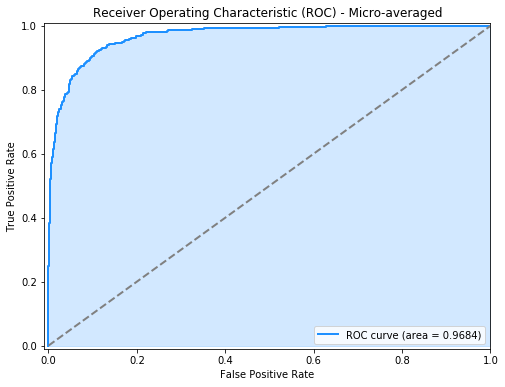

In [60]:
model_eval.roc_pr.rocplt_avg(yval, ypred, yprob)

> The AUC is pretty high at 96.84%.

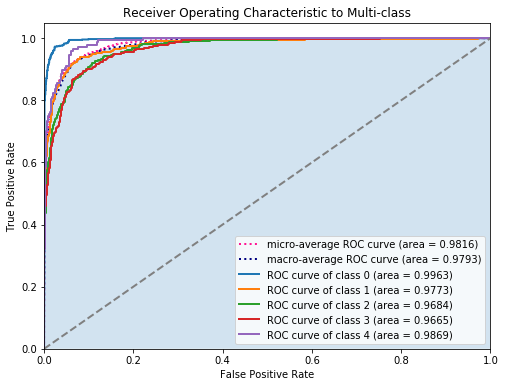

In [61]:
model_eval.roc_pr.rocplt_byclass(yval, ypred, yprob)

> The model has a strong prediction in class 0 (0-6 years old) when considering AUC for each class. This result correlates with the model performance in normalized confusion matrix. However, AUC of the age between 55-100 years old is at the 2nd rank and this result conflicts with normalized confustion matrix.<br>

>A possible reason of this conflict result is that ROC does not take the number of instances into account. Consequently, the matrix is not proper with imbalance target classes as this study. The more appropriate evaluation matrix PR curve.

- <b> PR Curve

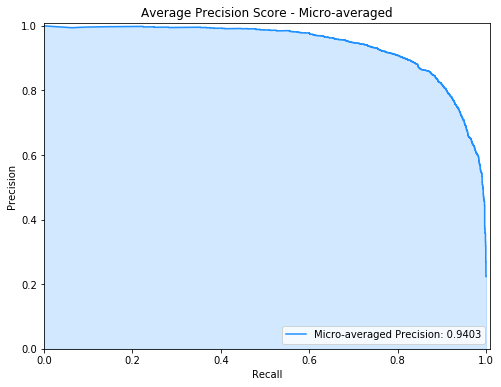

In [62]:
model_eval.roc_pr.prplt_avg(yval, ypred, yprob)

> The micro-average precision is just below 95%.

<Figure size 432x288 with 0 Axes>

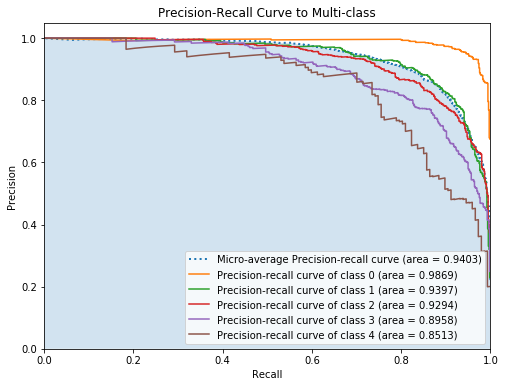

In [63]:
model_eval.roc_pr.prplt_byclass(yval, ypred, yprob)

> At this case, each class performace is in the same way as normalized confusion matrix. The best performance belongs to the class of 0-6 years old and the worst class is 55-100 yaers old.

- <b> Accuracy and F1

Finally to make sure that the model perforce is work for all classes, weighted accuracy and F1 are applied.

In [230]:
print('Weighted Accuracy: {:.4f}'.format(f1_score(yval, ypred, average='weighted')))
print('Weighted F1 Score: {:.4f}'.format(balanced_accuracy_score(yval, ypred)))

Weighted Accuracy: 0.8614
Weighted F1 Score: 0.8370


> Both weighted accuracy and F1 score are above 80%. As conclusion, this model performace is good [1].

### <b>6. Conclude and discuss the result

The best model performace is on VGG16 whcih adopts pre-train-weight from VGGFace. All model evalution matrixes reveal the same conclusion. However, the model is better when the weights at the top 2 layers are realesed. When realeasing more weight, the model performance declines dramatically. A possible reason is that the number of training instances is not enough to improve the model.<br>

This conclusion that VGG16 is better than ResNet50 makes sense as it is a lot shallow than ResNet50. Although ResNet50 uses residual block, there is no garuntee how many blocks are skipped. Additionally, VGG16 adopts weight from VGGFace which the problem is closer to this study problem, realted to human face, than ImageNet in ResNet50.<br>

Considering each prediction class, the model predicts 0-6 years old at the most accurate. Human face around the ages is also easily to differentiate from other age groups evthough it is the human task. Bad prediction is on 55-100 years old and this result cases by the lowest number of instances.

The <b>suggestion</b> for future analysis is to compare different model structure with different pre-train-weight and vice versa. Changing learning rate to see better accuarcy and loss across epcoh is also suggested. This experiment adopts default library learning rate and it is quite too much for using with pre-train-weight. Besides, it hardly see the differences in accuracy and loss across epcoh. Finally, changing input size to see how it affects the model performance is the possible experiment.

<b>Reference:</b><br>
[1] https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/